In [496]:
'''
Reading the MNIST/USPS Handwritten Digits Dataset
'''
'''
Dependencies
'''
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from itertools import permutations, combinations_with_replacement
import copy

def readData(fname='ZipDigits.train'):
    '''
    Input:
        fname: name of file containing N examples, each with d attributes
    Output:
        X: N x d+1 numpy array
        y: N x 1 numpy array
    '''
    with open(fname) as f:
        X = []
        y = []
        rlines = f.readlines()
        for line in rlines:
            row = line.rstrip().split(' ')
            yval = int(float(row[0]))
            if yval == 1 or yval == 5:
              y.append(yval)
              xvals = [float(pixel) for pixel in row[1:]]
              X.append(xvals)
        X = np.array(X)
        y = np.array(y)
        y = y.reshape((y.shape[0], 1))
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [497]:
'''
Read training and test datasets
'''
if True:
    Xdigitstrain, ydigitstrain = readData('ZipDigits.train')

    Ndigitstrain, pixels = Xdigitstrain.shape

    assert(Ndigitstrain == ydigitstrain.shape[0])

    print(f'Xdigitstrain shape {Xdigitstrain.shape}, ydigitstrain shape {ydigitstrain.shape}')

X shape: (1561, 256)
y shape: (1561, 1)
Xdigitstrain shape (1561, 256), ydigitstrain shape (1561, 1)


In [498]:
if True:
    Xdigitstest, ydigitstest = readData('ZipDigits.test')

    Ndigitstest, pixels = Xdigitstest.shape

    assert(Ndigitstest == ydigitstest.shape[0])

    print(f'Xdigitstest shape {Xdigitstest.shape}, ydigitstest shape {ydigitstest.shape}')

X shape: (424, 256)
y shape: (424, 1)
Xdigitstest shape (424, 256), ydigitstest shape (424, 1)


In [499]:
'''
Computing Features
'''


def computeIntensity(X):
    '''
    Compute the average intensity feature
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        intensities: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     average pixel intesity of the corresponding image
                     See LFD Example 3.1
    '''
    print('computing intensity feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    intensities = np.matmul(X, np.ones((d, 1)))/d
    print(f'Output shape {intensities.shape}')
    return intensities


def computeSymmetry(X):
    '''
    Compute the symmetry feature
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        symmetries: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     "horizontal" symmetry of the 16 x 16 image about the vertical axis
                     See LFD Example 3.1
    '''
    print('computing symmetry feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    Ximgs = [X[n, :].reshape((16, 16)) for n in range(N)]
    Ximgs_flipped = [np.flip(Ximgs[n], axis=1) for n in range(N)]
    symmetries = [np.sum(np.abs((Ximgs[n] - Ximgs_flipped[n])
                                ).reshape(256, ))/d for n in range(N)]
    symmetries = -np.array(symmetries)
    symmetries = symmetries.reshape(N, 1)
    print(f'Output shape {symmetries.shape}')
    return symmetries

In [500]:
'''
Computing the augmented feature matrix
'''


def computeAugmentedXWithFeatures(X):
    '''
    Compute the augmented feature matrix
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        Xaug: a 2 dimensional N x 3 numpy array
              the augmented feature matrix
              the i-th row corresponds to the i-th row of X (and image represented by it)
              the 0-th column is the column of 1s
              the 1-st column is the column of average intensities
              the 2-nd column is the column of horizontal symmetries
    '''
    N, d = X.shape
    intensity = computeIntensity(X)
    symmetry = computeSymmetry(X)
    dummy = np.ones((N, 1))
    Xaug = np.concatenate((dummy, intensity, symmetry), axis=1)
    print(f'Shape of augmented feature matrix: {Xaug.shape}')
    return Xaug

In [501]:
'''
Compute the augmented matrix with features
'''

print('Computing augmented training feature matrix')

Xaugtrain = computeAugmentedXWithFeatures(Xdigitstrain)

Naugtrain, d = Xaugtrain.shape

print('Computing augmented test feature matrix')

Xaugtest = computeAugmentedXWithFeatures(Xdigitstest)

Naugtest, d = Xaugtest.shape

Computing augmented training feature matrix
computing intensity feature
Input shape 1561, 256
Output shape (1561, 1)
computing symmetry feature
Input shape 1561, 256
Output shape (1561, 1)
Shape of augmented feature matrix: (1561, 3)
Computing augmented test feature matrix
computing intensity feature
Input shape 424, 256
Output shape (424, 1)
computing symmetry feature
Input shape 424, 256
Output shape (424, 1)
Shape of augmented feature matrix: (424, 3)


In [502]:
'''
Create the dataset wih digits 1 and 5
'''


def indexDigits(y):
    '''
    A helper function to locate examples by label
    Input:
        y: N x 1 2 dimensional numpy array; labels for handwritten digits
    Output:
        digit_idxs: a dictionary; the keys are digits 0 -- 9
                    for a digit k, digit_idxs[k] is a list identifying the rows labeled with digit k
    '''
    N = y.shape[0]
    digit_idxs = {}
    for n in range(N):
        digit = ydigitstrain[n, 0]
        if not digit in digit_idxs:
            digit_idxs[digit] = []
        digit_idxs[digit].append(n)
    return digit_idxs

In [503]:
'''
Construct the training and test sets for the rest of the exercises on classifying 1s vs 5s
'''

if True:
    digit_idxs_train = indexDigits(Xaugtrain)
    X1train = Xaugtrain[digit_idxs_train[1], :]
    print(X1train)
    N1train = X1train.shape[0]
    print(f'number of 1s: {N1train}')
    X5train = Xaugtrain[digit_idxs_train[5], :]
    print(X5train)
    N5train = X5train.shape[0]
    print(f'number of 5s: {N5train}')

    Xtrain = Xaugtrain[digit_idxs_train[1]+digit_idxs_train[5], :]
    ytrain = np.concatenate(
        (np.ones((N1train, 1)), -1*np.ones((N5train, 1))), axis=0)
    Ntrain, d = Xtrain.shape
    print(f'number of 1s and 5s: {Ntrain}')
    print(f'Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}')

    digit_idxs_test = indexDigits(Xaugtest)

    X1test = Xaugtest[digit_idxs_test[1], :]
    X5test = Xaugtest[digit_idxs_test[5], :]

    Xtest = Xaugtest[digit_idxs_test[1]+digit_idxs_test[5], :]
    ytest = np.concatenate((np.ones((len(digit_idxs_test[1]), 1)), -1*np.ones((len(digit_idxs_test[5]), 1))), axis=0)
    Ntest, d = Xtest.shape
    print(f'number of 1s and 5s: {Ntest}')
    print(f'Xtest shape: {Xtest.shape}, ytest shape: {ytest.shape}')

[[ 1.         -0.75391406 -0.1174375 ]
 [ 1.         -0.77228125 -0.16229688]
 [ 1.         -0.76925781 -0.0595    ]
 ...
 [ 1.         -0.60979297 -0.21638281]
 [ 1.         -0.66230859 -0.09282031]
 [ 1.         -0.44755859 -0.13085156]]
number of 1s: 1005
[[ 1.         -0.11173828 -0.53372656]
 [ 1.         -0.56403516 -0.40299219]
 [ 1.         -0.392      -0.3865625 ]
 ...
 [ 1.         -0.26407812 -0.662     ]
 [ 1.         -0.28941406 -0.58520312]
 [ 1.         -0.53423828 -0.51378906]]
number of 5s: 556
number of 1s and 5s: 1561
Xtrain shape: (1561, 3), ytrain shape: (1561, 1)
number of 1s and 5s: 424
Xtest shape: (424, 3), ytest shape: (424, 1)


In [504]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

In [505]:
svm_model = svm.SVC(kernel='linear')
param_grid = {'C': np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(Xtrain, ytrain)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [506]:
bestValC = grid_search.best_params_['C']
bestSvmModel = grid_search.best_estimator_
Ecv = 1 - grid_search.best_score_
print(f"Best Regularization Parameter: {bestValC}")
print(f"Ecv for Best Regularization {bestValC} is: {Ecv}")

Best Regularization Parameter: 100.0
Ecv for Best Regularization 100.0 is: 0.017297452281477832


In [507]:
bestSvmModel.fit(Xtrain, ytrain)
Ein = 1 - bestSvmModel.score(Xtrain, ytrain)
print(f"Ein for SVM Model: {Ein}")


Ein for SVM Model: 0.01665598975016014


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [508]:
Etest = 1 - bestSvmModel.score(Xtest, ytest)
print(f"Etest for SVM Model: {Etest}")

Etest for SVM Model: 0.41981132075471694


In [509]:
'''
Reading the MNIST/USPS Handwritten Digits Dataset
'''


def readData(fname='ZipDigits.train'):
    '''
    Input:
        fname: name of file containing N examples, each with d attributes
    Output:
        X: N x d+1 numpy array
        y: N x 1 numpy array
    '''
    with open(fname) as f:
        X = []
        y = []
        rlines = f.readlines()
        for line in rlines:
            row = line.rstrip().split(' ')
            yval = int(float(row[0]))
            y.append(yval)
            xvals = [float(pixel) for pixel in row[1:]]
            X.append(xvals)
        X = np.array(X)
        y = np.array(y)
        y = y.reshape((y.shape[0], 1))
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [510]:
'''
Read training and test datasets
'''
if True:
    Xdigitstrain, ydigitstrain = readData('ZipDigits.train')

    Ndigitstrain, pixels = Xdigitstrain.shape

    assert(Ndigitstrain == ydigitstrain.shape[0])

X shape: (7291, 256)
y shape: (7291, 1)


In [511]:
if True:
    Xdigitstest, ydigitstest = readData('ZipDigits.test')

    Ndigitstest, pixels = Xdigitstest.shape

    assert(Ndigitstest == ydigitstest.shape[0])

X shape: (2007, 256)
y shape: (2007, 1)


In [512]:
'''
Compute the augmented matrix with features
'''

if True:
    print('Computing augmented training feature matrix')

    Xaugtrain = computeAugmentedXWithFeatures(Xdigitstrain)

    Naugtrain, d = Xaugtrain.shape

    print('Computing augmented test feature matrix')

    Xaugtest = computeAugmentedXWithFeatures(Xdigitstest)

    Naugtest, d = Xaugtest.shape

Computing augmented training feature matrix
computing intensity feature
Input shape 7291, 256
Output shape (7291, 1)
computing symmetry feature
Input shape 7291, 256
Output shape (7291, 1)
Shape of augmented feature matrix: (7291, 3)
Computing augmented test feature matrix
computing intensity feature
Input shape 2007, 256
Output shape (2007, 1)
computing symmetry feature
Input shape 2007, 256
Output shape (2007, 1)
Shape of augmented feature matrix: (2007, 3)


In [513]:
Xaug = np.concatenate((Xaugtrain, Xaugtest), axis=0)
Naug, d = Xaug.shape
ycombined = np.concatenate((ydigitstrain, ydigitstest), axis=0)

assert(Xaug.shape[0] == Ndigitstrain + Ndigitstest)
assert(ycombined.shape[0] == Ndigitstrain + Ndigitstest)

print(f'Xaug shape {Xaug.shape}, ycombined shape {ycombined.shape}')

Xaug shape (9298, 3), ycombined shape (9298, 1)


In [514]:
def normalize(X, a=-1, b=1):
    N, d = X.shape
    Xnorm = np.ones((N, d))
    for col in range(1, d):
        Xcol = X[:, col]
        maxval = np.max(Xcol)
        minval = np.min(Xcol)
        xvaldiff = maxval - minval
        Xcolnorm = a + ((Xcol - minval) / xvaldiff)*(b-a)
        Xnorm[:, col] = Xcolnorm
    return Xnorm

In [515]:
Xnorm = normalize(Xaug)
N, d = Xnorm.shape

assert(Xnorm.shape == Xaug.shape)
assert(np.all(Xnorm[:, 0] == np.ones((N, 1)) ))

In [516]:
for n in range(N):
    if ycombined[n, 0] == 1:
        ycombined[n, 0] = 1
    else:
        ycombined[n, 0] = -1

In [517]:
def splitDataSelectKRandomly(X, y, K):
    '''
    Partitions the input dataset with N data points given by X and y into two parts,
    one with K of the data points selected uniformly at random, and
    the other with the remaining N-K data points
    Input:
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        K: an integer; number of data points to select
    Output:
        Xselected: a 2 dimensional K x d numpy array, K data points selected from X uniformly at random
        yselected: a 2 dimensional K x 1 numpy array, the labels from the input y corresponding to the examples selected in Xselected
        Xremaining: a 2 dimensional N-K x d numpy array
        yremaining: a 2 dimensional N-K x 1 numpy array
    '''
    N, d = X.shape
    selected_indices = np.random.choice(N, K, replace=False)
    remaining_indices = np.setdiff1d(np.arange(N), selected_indices)
    Xselected = X[selected_indices, :]
    yselected = y[selected_indices, :]
    Xremaining = X[remaining_indices, :]
    yremaining = y[remaining_indices, :]
    return Xselected, yselected, Xremaining, yremaining

In [518]:
X, y, Xtest, ytest = splitDataSelectKRandomly(Xnorm, ycombined, 300)

print(f'Xnorm shape {Xnorm.shape} ycombined shape {ycombined.shape}\n\
X shape {X.shape} y shape {y.shape}\n\
Xtest shape {Xtest.shape}, ytest shape {ytest.shape}')

Xnorm shape (9298, 3) ycombined shape (9298, 1)
X shape (300, 3) y shape (300, 1)
Xtest shape (8998, 3), ytest shape (8998, 1)


In [519]:
param_grid = {'svc__C':   np.logspace(-3, 3, 7)}

poly_svm_model = make_pipeline(PolynomialFeatures(degree=10), svm.SVC(kernel='linear'))

grid_search= GridSearchCV(poly_svm_model, param_grid, cv=5)
grid_search.fit(X, y)

bestCPoly = grid_search.best_params_['svc__C']

bestPolySvmModel = grid_search.best_estimator_

EcvPoly = 1 - grid_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [520]:
print(f"Best regularization parameter for Poly Transform Model: {bestCPoly}")
print(f"ECV for Best Regularization Parameter: {EcvPoly}")

Best regularization parameter for Poly Transform Model: 0.1
ECV for Best Regularization Parameter: 0.030000000000000027


In [521]:
bestPolySvmModel.fit(X, y)
EinPoly = 1 - bestPolySvmModel.score(X, y)
print(f"Ein for Poly Transform Model: {EinPoly}")

Ein for Poly Transform Model: 0.030000000000000027


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [522]:
EtestPoly = 1 - bestPolySvmModel.score(Xtest, ytest)
print(f"Etest for Poly Transform Model: {EtestPoly}")


Etest for Poly Transform Model: 0.033451878195154494


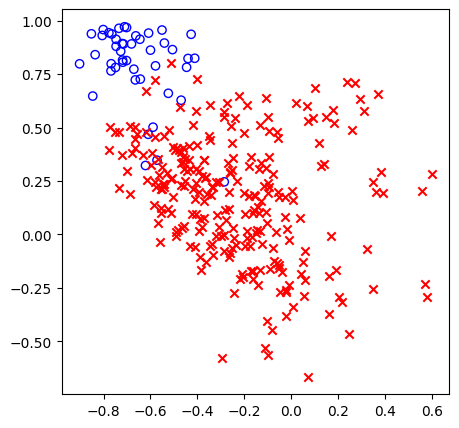

In [523]:
if True:
    fig, axs = plt.subplots(figsize=(5, 5))
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')

In [524]:
def vec2vecDistance(x, xprime, ord=2):
    '''
    Compute distance between two vectors
    Input:
        x: a d-dimensional numpy vector
        xprime: a d-dimensional vector
        ord: order of the norm used to compute distance
    Output:
        distance: a real number
    '''
    '''
    TODO:
    return ?
    Hint: See numpy.linalg.norm(..., ord=2)
    '''
    distance = np.linalg.norm(x - xprime, ord=ord)
    return distance

In [525]:
def vec2matDistances(x, X, ord=2):
    '''
    Compute distance between two vectors
    Input:
        x: a d-dimensional numpy vector
        X: a 2D N x d numpy array
        ord: order of the norm used to compute distance
    Output:
        distances: a 2D N x 1 numpy array of distances from x to data points in X
    '''
    '''
    TODO:
    return ?
    Hint: See numpy.linalg.norm(..., axis=1)
    '''
    distances = np.linalg.norm(X - x, ord=ord, axis=1)
    return distances

In [526]:
def classificationError(y, yhat):
    '''
    The (mis)classification error
    Input:
        y: a 2D N x 1 numpy array
        yhat: a 2D N x 1 numpy array
    Output:
        error: a real number, fraction of examples at which the value in y is not equal to the value in y
    '''
    N, d = y.shape
    error = np.sum((np.ones((N, 1)) - np.multiply(y, yhat)) / (2*N))
    return error

In [527]:
def regressionError(y, yhat):
    '''
    The (mis)classification error
    Input:
        y: a 2D N x 1 numpy array
        yhat: a 2D N x 1 numpy array
    Output:
        error: sum of squared "errors", the differences between the values in y and yhat
    '''
    N, d = y.shape
    error = (1/N) * ( np.matmul(yhat.T, yhat) - 2*np.matmul(yhat.T, y) + np.matmul(y.T, y) )[0, 0]
    return error

In [528]:
def kNN(X, y, xtest, k=3):
    '''
    The k Nearest Neighbors Algorithm
    Input:
        X: a 2D N x d numpy array
        y: a 2D N x 1 numpy array
        xtest: a d dimensional vector
        k: positive integer
    Output:
        ytest: prediction on xtest using the k Nearest Neighbors Algorithms and dataset X, y
    '''
    distances = vec2matDistances(xtest, X)
    '''
    kNeighbors = ?
    Hint: indices of the k nearest neighbors of xtest in X, see numpy.argpartition()
    ytest = ?
    Hint: Compute the average of the y values of the k nearest neighbors
    '''
    distances = vec2matDistances(xtest, X)
    kNeighbors = np.argpartition(distances, k)[:k]
    ytest = np.mean(y[kNeighbors])
    return ytest

In [529]:
def predictClasskNN(X, y, Xtest, k=3):
    '''
    Predict class using the k Nearest Neighbors Algorithm
    Input:
        X: a 2 dimensional N x d numpy array
        y: a 2 dimensional N x 1 numpy array
        Xtest: a 2D Ntest x d numpy array
        k: positive integer
    Output:
        ytest: a 2D Ntest x 1 anumpy array of predicted classes of examples in Xtest
    '''
    N, d = Xtest.shape
    yhat = np.zeros((N, 1))
    for n in range(N):
        xtest = Xtest[n, :]
        '''
        TODO:
        yhat[n, 0] = np.sign(?)
        '''
        distances = vec2matDistances(xtest, X)
        kNeighbors = np.argpartition(distances, k)[:k]
        yhat[n, 0] = np.sign(np.mean(y[kNeighbors]))
    return yhat

In [530]:
def plotkNNSeparator(X, y, k=3, title=''):
    '''
    Plot the "effective" decision boundary and half spaces
    determined by the k Nearest Neighbors Algorithm
    Input:
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0], ..., X[n, d-1] have values of features
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        k: positive integer
        title: a string
    Output:
        No output
    '''
    fig, axs = plt.subplots(figsize=(10, 10))
    '''
    Plot separator
    '''
    pltx1s = np.linspace(-1, 1, 250)
    pltx2s = np.linspace(-1, 1, 250)
    pltX = np.array([[1, x, y] for x in pltx1s for y in pltx2s])
    pltyhat = predictClasskNN(X, y, pltX, k=k)
    pltx1s = pltX[:, 1].reshape((pltX.shape[0], 1))
    pltx2s = pltX[:, 2].reshape((pltX.shape[0], 1))
    cmap = ListedColormap(['lightcoral', 'lightskyblue'])
    axs.scatter(pltx1s, pltx2s, c=pltyhat, cmap=cmap)
    '''
    Plot data points
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')
    '''
    Finishing touches
    '''
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_title(title)
    axs.legend()
    plt.show()

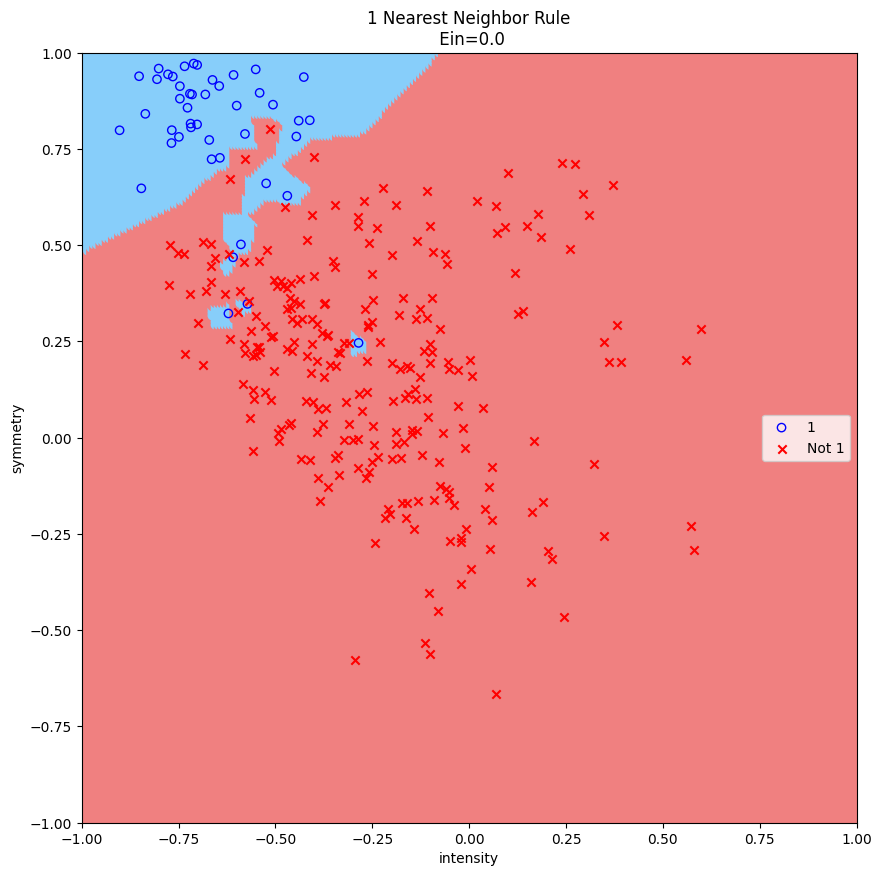

In [531]:
k=1

yhat = predictClasskNN(X, y, X, k=k)
Ein = classificationError(y, yhat)

plotkNNSeparator(X, y, k=k, title=f'{k} Nearest Neighbor Rule\n Ein={Ein}')

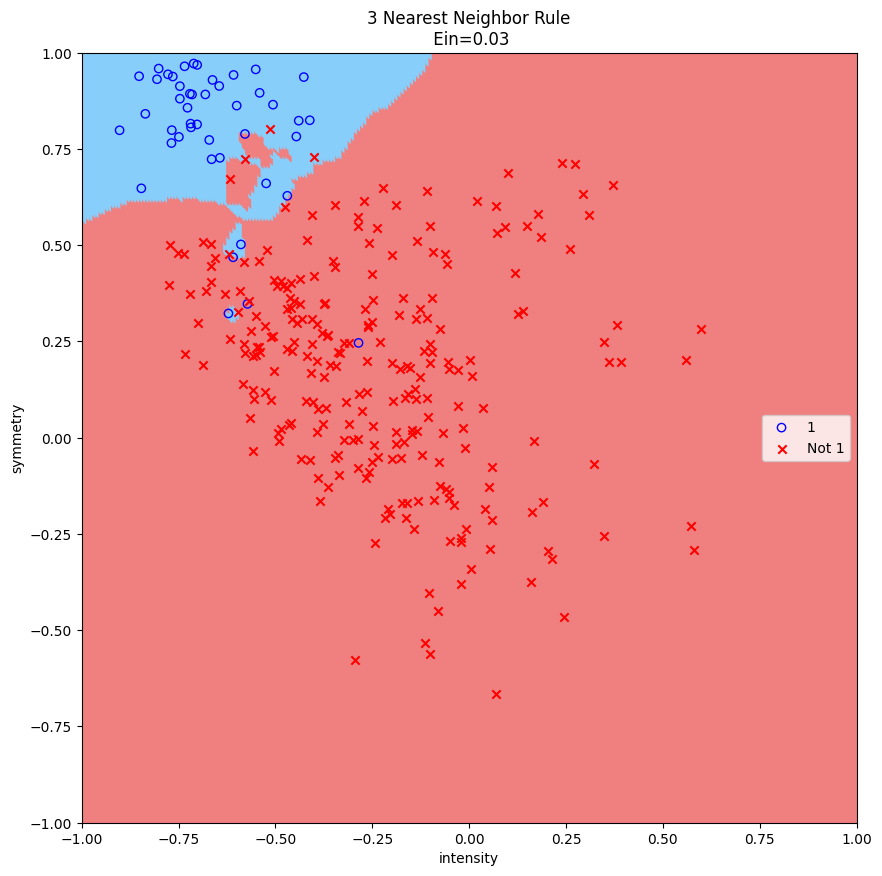

In [532]:
k=3

yhat = predictClasskNN(X, y, X, k=3)
Ein = classificationError(y, yhat)

plotkNNSeparator(X, y, k=k, title=f'{k} Nearest Neighbor Rule\n Ein={Ein}')

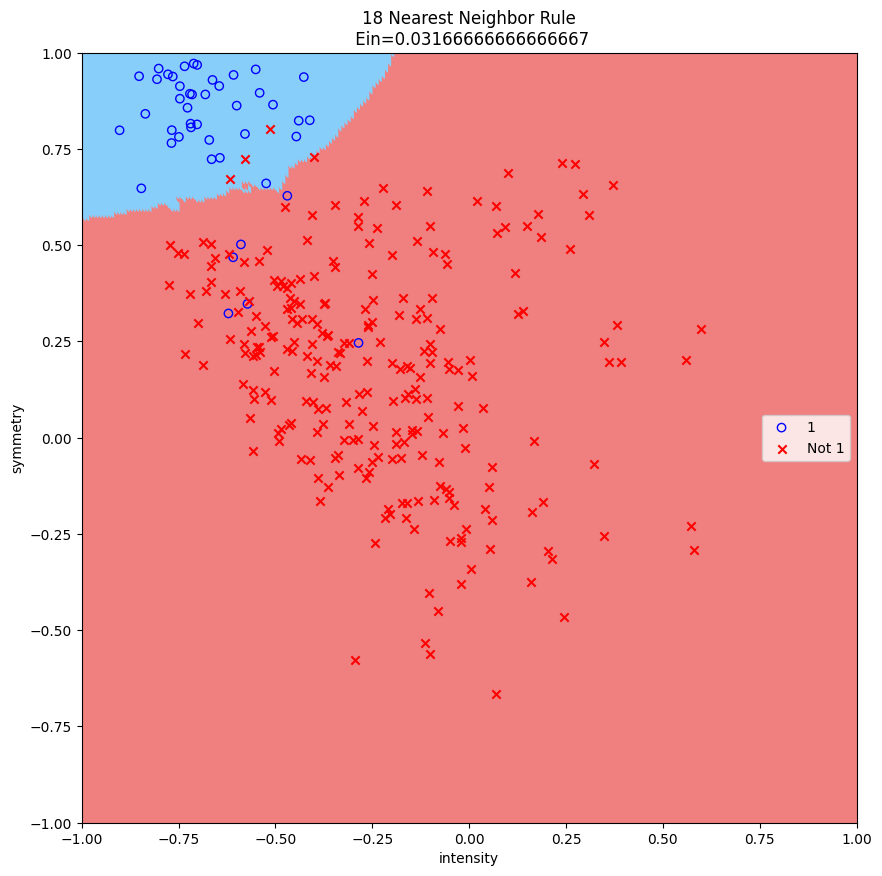

In [533]:
N, d = X.shape
k = np.ceil(np.sqrt(N)).astype(int)

yhat = predictClasskNN(X, y, X, k=k)
Ein = classificationError(y, yhat)

plotkNNSeparator(X, y, k=k, title=f'{k} Nearest Neighbor Rule\n Ein={Ein}')

In [534]:
def Error(X, y, k):
    N, d = X.shape
    num_folds = 7
    cross_validation_error = 0
    fold_size = N // num_folds
    for fold in range(num_folds):
        start_idx = fold * fold_size
        end_idx = (fold + 1) * fold_size
        X_train = np.vstack((X[:start_idx, :], X[end_idx:, :]))
        validation_X = X[start_idx:end_idx, :]
        y_train = np.vstack((y[:start_idx, :], y[end_idx:, :]))
        validation_y = y[start_idx:end_idx, :]
        yhat_valid = predictClasskNN(X_train, y_train, validation_X, k=k)
        cross_validation_error += classificationError(validation_y, yhat_valid)
    return cross_validation_error

Cross Validation with k=1, Ecv = 0.30952380952380953
Cross Validation with k=2, Ecv = 0.35714285714285715
Cross Validation with k=3, Ecv = 0.3095238095238095
Cross Validation with k=4, Ecv = 0.3333333333333333
Cross Validation with k=5, Ecv = 0.26190476190476186
Cross Validation with k=6, Ecv = 0.25
Cross Validation with k=7, Ecv = 0.26190476190476186
Cross Validation with k=8, Ecv = 0.26190476190476186
Cross Validation with k=9, Ecv = 0.26190476190476186
Cross Validation with k=10, Ecv = 0.26190476190476186
Cross Validation with k=11, Ecv = 0.26190476190476186
Cross Validation with k=12, Ecv = 0.25
Cross Validation with k=13, Ecv = 0.26190476190476186
Cross Validation with k=14, Ecv = 0.26190476190476186
Cross Validation with k=15, Ecv = 0.26190476190476186
Cross Validation with k=16, Ecv = 0.26190476190476186
Cross Validation with k=17, Ecv = 0.26190476190476186
Cross Validation with k=18, Ecv = 0.2619047619047619
Cross Validation with k=19, Ecv = 0.26190476190476186


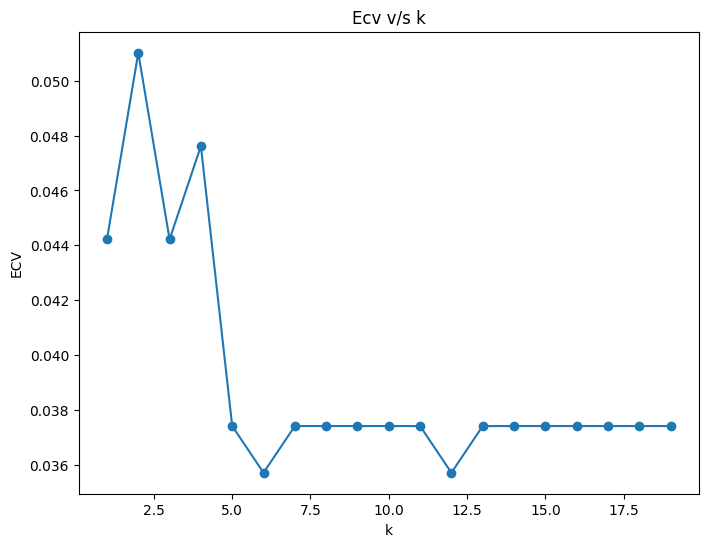

Optimal value of k from cross validation is: 6


In [537]:
kRange = range(1, 20)
Ecvs = []
folds = 7
for k in kRange:
    Ecv = Error(X, y, k)
    print(f'Cross Validation with k={k}, Ecv = {Ecv}')
    Ecv /= folds
    Ecvs.append(Ecv)

plt.figure(figsize=(8, 6))
plt.plot(kRange, Ecvs, marker='o', linestyle='-')
plt.xlabel('k')
plt.ylabel('ECV')
plt.title('Ecv v/s k')
plt.show()

optimal_k = kRange[np.argmin(Ecvs)]
print('Optimal value of k from cross validation is:', optimal_k)

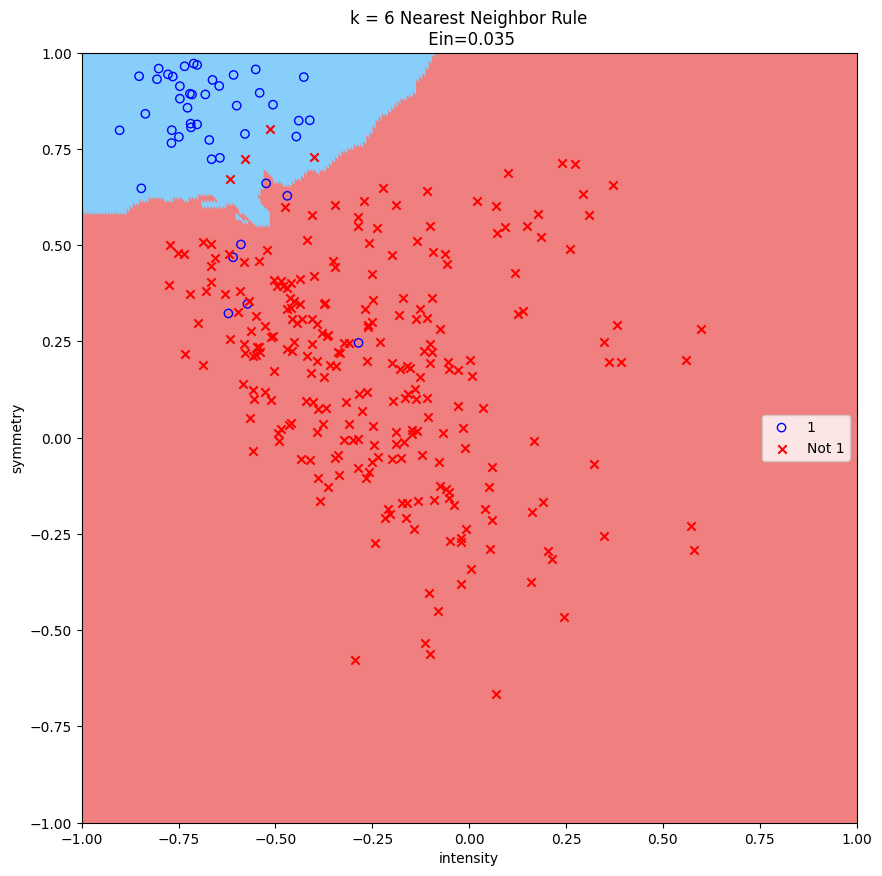

The value of Etest:  0.035
The value of Ecv:  0.25


In [538]:
yhatOptimalK = predictClasskNN(X, y, X, optimal_k)
ETest = classificationError(y, yhatOptimalK)
Ecv_optimal_k = Error(X, y, optimal_k)
plotkNNSeparator(X, y, optimal_k, title=f'k = {optimal_k} Nearest Neighbor Rule\n Ein={ETest}')
print('The value of Etest: ', ETest)
print('The value of Ecv: ', Ecv_optimal_k)


In [540]:
yhat_optimal_k = predictClasskNN(X, y, Xtest, optimal_k)
Etest_optimal_k = classificationError(ytest, yhat_optimal_k)
print(f'The value of Etest for value of k={optimal_k} is: ', Etest_optimal_k)


The value of Etest for value of k=6 is:  0.03350744609913314
